In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime

In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series.dropna())
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] < 0.05:
        print("p-value < 0.05. Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("p-value >= 0.05. Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [4]:
# load dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')

In [5]:
milk = pd.read_csv("milk.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
milk = milk.asfreq('MS')
milk

,Milk
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


<AxesSubplot:xlabel='Month'>

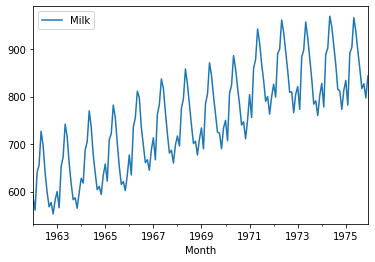

In [6]:
milk.plot()

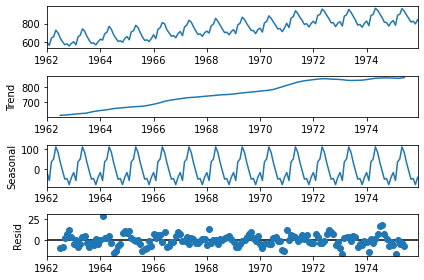

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(milk)
decomposed.plot()
plt.show()

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


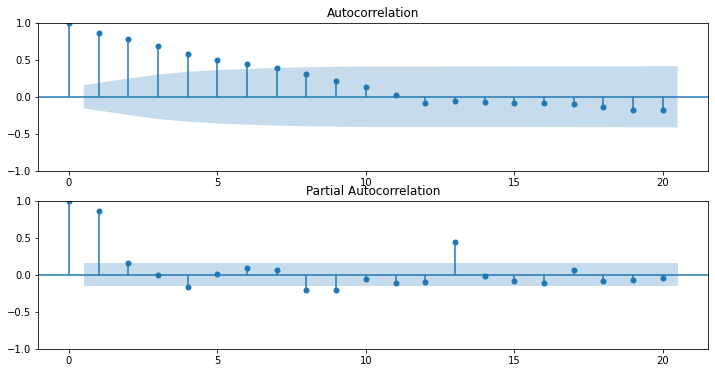

In [8]:
# Stationary data
month_diff = milk.diff(12).dropna()
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(month_diff, ax=ax[0], lags=20)
ax[1] = plot_pacf(month_diff, ax=ax[1], lags=20)

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


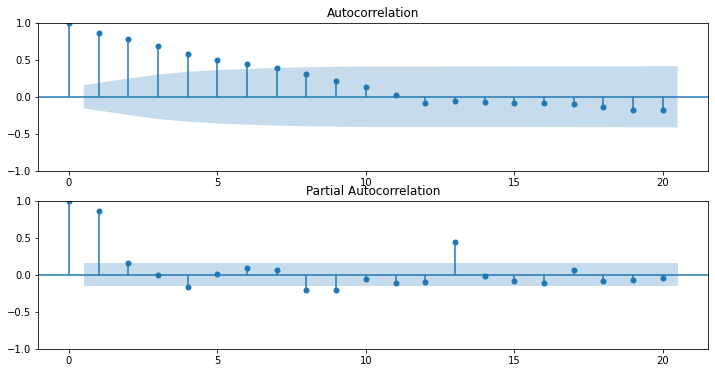

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359397
p-value : 0.16079880527711382
Number of Lags Used : 12
Number of Observations Used : 143
p-value >= 0.05. Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


In [16]:
seasonal_first_diff = milk.diff(12).dropna()
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(seasonal_first_diff, ax=ax[0], lags=20)
ax[1] = plot_pacf(seasonal_first_diff, ax=ax[1], lags=20)
# plt.savefig("acf_pacf_seasonaldiff_data", bbox_inches="tight")
plt.show()
adf_check(seasonal_first_diff)

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


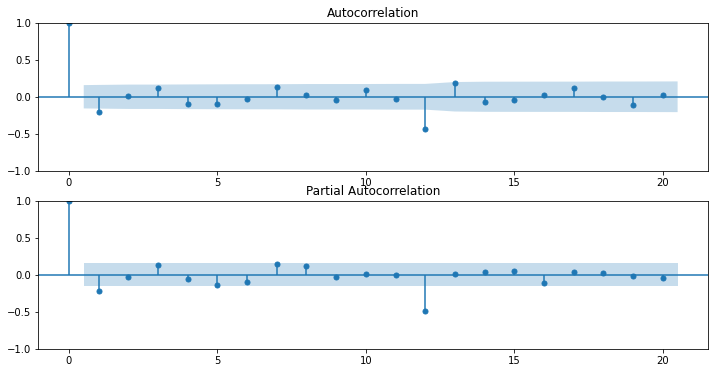

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921979
p-value : 1.865423431878876e-05
Number of Lags Used : 11
Number of Observations Used : 143
p-value < 0.05. Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [18]:
seasonal_nonseasonal_first_diff = milk.diff(12).diff().dropna()
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(seasonal_nonseasonal_first_diff, ax=ax[0], lags=20)
ax[1] = plot_pacf(seasonal_nonseasonal_first_diff, ax=ax[1], lags=20)
# plt.savefig("acf_pacf_seasonaldiff_nonseasonaldiff_data", bbox_inches="tight")
plt.show()
adf_check(seasonal_nonseasonal_first_diff)

                                      SARIMAX Results                                       
Dep. Variable:                                 Milk   No. Observations:                  168
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -534.194
Date:                              Fri, 29 Oct 2021   AIC                           1076.388
Time:                                      01:18:51   BIC                           1088.588
Sample:                                  01-01-1962   HQIC                          1081.343
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7698      0.078      9.873      0.000       0.617       0.923
ar.L2          0.22

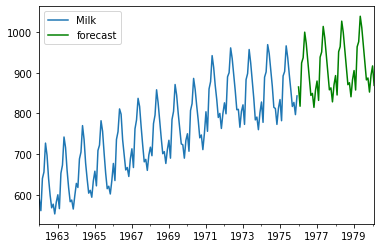

            Milk  predictions
Month                        
1962-01-01   589     0.000000
1962-02-01   561     0.367056
1962-03-01   640     0.703782
1962-04-01   656     1.075202
1962-05-01   727     1.441042
...          ...          ...
1975-08-01   858   855.164700
1975-09-01   817   808.298625
1975-10-01   827   817.173925
1975-11-01   797   788.422467
1975-12-01   843   835.204921

[168 rows x 2 columns]


In [101]:
from pmdarima import auto_arima

# model = auto_arima(milk["Milk"], m=12, seasonal=True)
model = SARIMAX(milk["Milk"], order=(2,0,0), seasonal_order=(0,1,1,12))
model = model.fit()
print(model.summary())

milk["predictions"] = model.predict()
pd.concat([milk["Milk"], pd.Series(model.forecast(50), name="forecast")], axis=1).plot(color=["C0", "green"])
# milk.plot()
plt.savefig("SARIMA_200_011_12_forecast")
plt.show()
print(milk)

                                     SARIMAX Results                                      
Dep. Variable:                               Milk   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -530.032
Date:                            Fri, 29 Oct 2021   AIC                           1068.064
Time:                                    01:19:08   BIC                           1080.238
Sample:                                01-01-1962   HQIC                          1073.009
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1346      0.334     -0.403      0.687      -0.790       0.520
ma.L1         -0.0969      0.334   

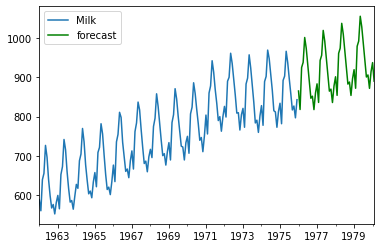

In [104]:
model = SARIMAX(milk["Milk"], order=(1,1,1), seasonal_order=(0,1,1,12))
model = model.fit()
print(model.summary())

milk["predictions"] = model.predict()
# milk.plot()
pd.concat([milk["Milk"], pd.Series(model.forecast(50), name="forecast")], axis=1).plot(color=["C0", "green"])
plt.savefig("SARIMA_111_011_12_forecast")
plt.show()

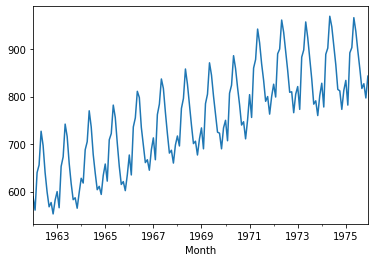

In [90]:
milk["Milk"].plot()
plt.savefig("milk")